# Predicting Breast Cancer with Cell Characteristics

# Questions to Answer:
 
 1.	What features of a cell are the largest drivers of malignancy?
 2.	How would a physician use your product?
 3.	How to determine the most cost-effective way of collecting cell features to detect malignancy?
 
# Executive Summary:
  1. Uniformity of Cell Size, Uniformity of Cell Shape, and Bare Nuclei are the biggest drivers of malignancy. 
  2. A physician can focus more on the three important features when examining a patient, or use the random forest model I built to screen patients more efficiently. 
  3. Since uniformity of cell size and uniformity of cell shape are highly correlated, we only need to select one feature to measure. Then measure marginal adhesion and bare nuclei. 

## Feature Descriptions:
Sample code number: id number
<br>Clump Thickness: 1 - 10
<br>Uniformity of Cell Size: 1 - 10
<br>Uniformity of Cell Shape: 1 - 10
<br>Marginal Adhesion: 1 - 10
<br>Single Epithelial Cell Size: 1 - 10
<br>Bare Nuclei: 1 - 10
<br>Bland Chromatin: 1 - 10
<br>Normal Nucleoli: 1 - 10
<br>Mitoses: 1 - 10
<br>Class: 2 for benign, 4 for malignant

## Load Python Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

## Import Data 

In [2]:
cancer_data = pd.read_csv(r"C:\Users\diana\Dropbox\Insight\Copy of breast-cancer-wisconsin.txt", index_col=0)
cancer_data.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4


In [3]:
#examine data types, shape of dataframe, data duplicates.
print(cancer_data.dtypes)
print(cancer_data.shape)
cancer_data = cancer_data.drop_duplicates()
print(cancer_data.shape)

ID                              int64
Clump Thickness                 int64
Uniformity of Cell Size        object
Uniformity of Cell Shape       object
Marginal Adhesion              object
Single Epithelial Cell Size    object
Bare Nuclei                    object
Bland Chromatin                object
Normal Nucleoli                object
Mitoses                        object
Class                          object
dtype: object
(15855, 11)
(754, 11)


## Check missing data, unique values in each feature

In [4]:
#count missing values in all the columns
def missing_val(df):
    for col in df.columns:
        print('number of missing values in '+ col + ' is ' + str(df[col].isnull().sum()))
    return None

In [5]:
missing_val(cancer_data)

number of missing values in ID is 0
number of missing values in Clump Thickness is 0
number of missing values in Uniformity of Cell Size is 13
number of missing values in Uniformity of Cell Shape is 13
number of missing values in Marginal Adhesion is 13
number of missing values in Single Epithelial Cell Size is 13
number of missing values in Bare Nuclei is 13
number of missing values in Bland Chromatin is 13
number of missing values in Normal Nucleoli is 13
number of missing values in Mitoses is 13
number of missing values in Class is 13


In [6]:
#take a look at the rows with missing data, if all 13 missing rows are the same, drop them
cancer_data[cancer_data['Bland Chromatin'].isnull()]
cancer_data = cancer_data.dropna()
print(cancer_data.shape)

(741, 11)


In [7]:
#count unique values in all columns
def identify_unique(df):
    for col in df.columns:
        print(str(df[col].nunique()) + ' unique values in ' + col)
    return None

In [8]:
identify_unique(cancer_data)

666 unique values in ID
17 unique values in Clump Thickness
21 unique values in Uniformity of Cell Size
19 unique values in Uniformity of Cell Shape
20 unique values in Marginal Adhesion
19 unique values in Single Epithelial Cell Size
19 unique values in Bare Nuclei
19 unique values in Bland Chromatin
22 unique values in Normal Nucleoli
14 unique values in Mitoses
7 unique values in Class


In [9]:
#document unique values and their frequencies in all columns
def record_unique(df):
    feature_value = []
    for col in df.columns:
        feature_value.append(pd.DataFrame(df[col].value_counts()).reset_index())
    features = pd.concat(feature_value, axis=1)
    return features

In [10]:
features_data = record_unique(cancer_data)
features_data.head(20)
#some features have entries beyond the 1~10 range, with values like "No Idea", "?", or "#". remove these rows

,index,ID,index,Clump Thickness,index,Uniformity of Cell Size,index,Uniformity of Cell Shape,index,Marginal Adhesion,...,index,Bare Nuclei,index,Bland Chromatin,index,Normal Nucleoli,index,Mitoses,index,Class
0,1182404,6,1.0,142.0,1,377.0,1,346.0,1,399.0,...,1,395.0,2,165.0,1,435.0,1,569.0,2,451.0
1,1276091,5,5.0,129.0,10,67.0,2,59.0,10,58.0,...,10,134.0,3,160.0,10,66.0,2,35.0,4,237.0
2,1241035,4,3.0,108.0,3,51.0,10,59.0,3,58.0,...,2,30.0,1,150.0,3,42.0,3,32.0,40,17.0
3,1110524,4,4.0,80.0,2,45.0,3,56.0,2,56.0,...,5,30.0,7,71.0,2,36.0,10,31.0,?,12.0
4,1106829,4,10.0,79.0,4,40.0,4,44.0,4,33.0,...,?,28.0,4,40.0,8,24.0,4,12.0,No idea,10.0
5,1198641,4,8.0,52.0,5,30.0,5,33.0,8,25.0,...,3,28.0,5,34.0,6,22.0,?,12.0,#,9.0
6,1200892,3,2.0,50.0,8,29.0,7,30.0,5,23.0,...,8,20.0,8,28.0,5,19.0,No idea,10.0,20,5.0
7,1226612,3,6.0,34.0,6,27.0,6,30.0,6,22.0,...,4,19.0,10,20.0,4,18.0,#,9.0,NaN,NaN
8,1112209,3,7.0,32.0,7,19.0,8,28.0,7,13.0,...,No idea,10.0,?,12.0,9,16.0,7,9.0,NaN,NaN
9,691628,3,9.0,13.0,?,12.0,?,12.0,?,12.0,...,9,9.0,9,11.0,7,16.0,8,8.0,NaN,NaN


In [11]:
mask = (cancer_data['Uniformity of Cell Size']=='No idea') | (cancer_data['Class']=='#') | (cancer_data['Class'] =='?')
cancer_data = cancer_data[~mask]

In [12]:
print(cancer_data.shape)

(710, 11)


In [13]:
features_data = record_unique(cancer_data)
features_data.head(20)

,index,ID,index,Clump Thickness,index,Uniformity of Cell Size,index,Uniformity of Cell Shape,index,Marginal Adhesion,...,index,Bare Nuclei,index,Bland Chromatin,index,Normal Nucleoli,index,Mitoses,index,Class
0,1182404,6,1.0,141.0,1,377.0,1,346.0,1,399.0,...,1,395.0,2,165.0,1,435.0,1,569.0,2,451.0
1,1276091,5,5.0,128.0,10,67.0,10,59.0,10,58.0,...,10,134.0,3,160.0,10,66.0,2,35.0,4,237.0
2,1238777,2,3.0,106.0,3,51.0,2,59.0,3,58.0,...,5,30.0,1,150.0,3,42.0,3,32.0,40,17.0
3,1143978,2,4.0,80.0,2,45.0,3,56.0,2,56.0,...,2,30.0,7,71.0,2,36.0,10,31.0,20,5.0
4,560680,2,10.0,70.0,4,40.0,4,44.0,4,33.0,...,3,28.0,4,40.0,8,24.0,4,12.0,NaN,NaN
5,1174057,2,2.0,50.0,5,30.0,5,33.0,8,25.0,...,8,20.0,5,34.0,6,22.0,7,9.0,NaN,NaN
6,822829,2,8.0,46.0,8,29.0,6,30.0,5,23.0,...,4,19.0,8,28.0,5,19.0,8,8.0,NaN,NaN
7,1198641,2,6.0,33.0,6,27.0,7,30.0,6,22.0,...,?,16.0,10,20.0,4,18.0,5,6.0,NaN,NaN
8,1212422,2,7.0,23.0,7,19.0,8,28.0,7,13.0,...,9,9.0,9,11.0,9,16.0,20,4.0,NaN,NaN
9,1354840,2,9.0,12.0,9,6.0,9,7.0,30,6.0,...,7,8.0,6,10.0,7,16.0,6,3.0,NaN,NaN


#### 'Bare Nuclei' still has entries like "?", remove them or fill them with reasonable values.

In [14]:
cancer_data[cancer_data['Bare Nuclei']=='?']

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
157,1057067,1,1,1,1,1,?,1,1,1,2
1144,1238464,1,1,1,1,1,?,2,1,1,2
1799,169356,3,1,1,1,2,?,3,1,1,2
2398,563649,8,8,8,1,2,?,6,10,1,4
3727,61634,5,4,3,1,2,?,2,3,1,2
5059,1096800,6,6,6,9,6,?,7,8,1,2
6563,1241232,3,1,4,1,2,?,3,1,1,2
6752,1193683,1,1,2,1,3,?,1,1,1,2
7122,432809,3,1,3,1,2,?,2,1,1,2


There are 16 cases where Bare Nuclei has "?" entries. This seem to be a somewhat important feature. Let's keep it and assign a new value to it, 11, to indicate it's something we filled in. 

In [15]:
cancer_data.loc[cancer_data['Bare Nuclei']=='?','Bare Nuclei']=11

### Some values of these features are multiples of 10, which seems like data errors that are fixable. Divide these values by 10 and keep the results (rounded to integer).

In [16]:
cancer_data.dtypes

ID                              int64
Clump Thickness                 int64
Uniformity of Cell Size        object
Uniformity of Cell Shape       object
Marginal Adhesion              object
Single Epithelial Cell Size    object
Bare Nuclei                    object
Bland Chromatin                object
Normal Nucleoli                object
Mitoses                        object
Class                          object
dtype: object

### Some columns are still "object" instead of numerical, convert them into numericals and then divide by 10

In [17]:
cancer_data = cancer_data.apply(pd.to_numeric)

In [18]:
def convert_outlier(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x/10 if x>10 else x)
    return df

In [19]:
clean_data = convert_outlier(cancer_data)

In [20]:
features_data = record_unique(clean_data)
features_data.head(10)

,index,ID,index,Clump Thickness,index,Uniformity of Cell Size,index,Uniformity of Cell Shape,index,Marginal Adhesion,...,index,Bare Nuclei,index,Bland Chromatin,index,Normal Nucleoli,index,Mitoses,index,Class
0,118240.4,6,1.0,141.0,1.0,377.0,1.0,346.0,1.0,399.0,...,1.0,395.0,2.0,168.0,1.0,435.0,1.0,569.0,2.0,456.0
1,127609.1,5,5.0,129.0,10.0,71.0,10.0,61.0,3.0,64.0,...,10.0,140.0,3.0,168.0,10.0,67.0,2.0,39.0,4.0,254.0
2,107093.5,2,3.0,108.0,3.0,53.0,2.0,59.0,10.0,62.0,...,2.0,32.0,1.0,150.0,3.0,45.0,3.0,32.0,NaN,NaN
3,111619.2,2,4.0,83.0,2.0,47.0,3.0,58.0,2.0,57.0,...,5.0,32.0,7.0,76.0,2.0,38.0,10.0,31.0,NaN,NaN
4,121242.2,2,10.0,75.0,4.0,41.0,4.0,49.0,4.0,35.0,...,3.0,30.0,4.0,41.0,8.0,26.0,4.0,12.0,NaN,NaN
5,124060.3,2,2.0,50.0,5.0,33.0,5.0,36.0,8.0,25.0,...,8.0,24.0,5.0,35.0,6.0,24.0,7.0,10.0,NaN,NaN
6,132007.7,2,8.0,49.0,6.0,31.0,6.0,34.0,5.0,25.0,...,4.0,19.0,8.0,28.0,5.0,21.0,8.0,8.0,NaN,NaN
7,106199.0,2,6.0,35.0,8.0,31.0,7.0,32.0,6.0,24.0,...,1.1,16.0,10.0,20.0,4.0,20.0,5.0,6.0,NaN,NaN
8,82282.9,2,7.0,28.0,7.0,19.0,8.0,28.0,7.0,14.0,...,9.0,9.0,6.0,13.0,9.0,17.0,6.0,3.0,NaN,NaN
9,56068.0,2,9.0,12.0,9.0,7.0,9.0,7.0,9.0,5.0,...,7.0,8.0,9.0,11.0,7.0,17.0,NaN,NaN,NaN,NaN


In [21]:
identify_unique(clean_data)

665 unique values in ID
10 unique values in Clump Thickness
10 unique values in Uniformity of Cell Size
10 unique values in Uniformity of Cell Shape
10 unique values in Marginal Adhesion
10 unique values in Single Epithelial Cell Size
11 unique values in Bare Nuclei
10 unique values in Bland Chromatin
10 unique values in Normal Nucleoli
9 unique values in Mitoses
2 unique values in Class


### Generat the descriptive stats and bar plots of features. 

In [22]:
def describe_data(df):
    des_stat = pd.DataFrame(df.describe()).reset_index()
    return des_stat
des_stat = describe_data(clean_data)
des_stat

,index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,count,7.100000e+02,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
1,mean,1.366280e+05,4.504225,3.238028,3.294366,2.925352,3.219718,3.607887,3.467606,2.992958,1.807042,2.715493
2,std,1.802607e+05,2.835770,3.091636,2.988808,2.925267,2.183321,3.662680,2.434691,3.122999,2.139878,0.959350
3,min,6.163400e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
4,25%,8.882575e+04,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
5,50%,1.174033e+05,4.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
6,75%,1.241649e+05,6.000000,5.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.000000,4.000000
7,max,1.345435e+06,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [23]:
clean_data = clean_data.drop(['ID'], axis=1)

In [24]:
def cast_cat(df):
    for col in df.columns:
        df[col] = df[col].astype('category')
    return df
clean_data = cast_cat(clean_data)

In [25]:
clean_data.dtypes

Clump Thickness                category
Uniformity of Cell Size        category
Uniformity of Cell Shape       category
Marginal Adhesion              category
Single Epithelial Cell Size    category
Bare Nuclei                    category
Bland Chromatin                category
Normal Nucleoli                category
Mitoses                        category
Class                          category
dtype: object

In [26]:
clean_data = clean_data.reset_index(drop=True)
clean_data.tail(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
700,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0
701,6.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0
702,2.0,2.0,2.0,1.0,1.0,1.0,7.0,1.0,1.0,2.0
703,8.0,10.0,10.0,8.0,6.0,9.0,3.0,10.0,10.0,4.0
704,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0
705,10.0,1.0,1.0,1.0,2.0,10.0,5.0,4.0,1.0,4.0
706,4.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0
707,5.0,8.0,8.0,10.0,5.0,10.0,8.0,10.0,3.0,4.0
708,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,2.0
709,10.0,4.0,6.0,1.0,2.0,10.0,5.0,3.0,1.0,4.0


In [27]:
clean_data.to_csv(r"C:\Users\diana\Dropbox\Insight\clean_breast_cancer.csv")

TypeError: 'AxesSubplot' object does not support item assignment

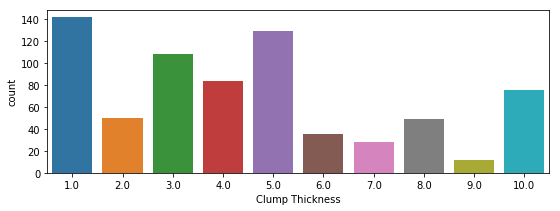

In [158]:
def count_plot(df):
    fig, axs = plt.subplots(figsize=(9, 3), sharey=True)
    cols = list(df.columns)
    for i in range(0, len(df.columns)):
        axs[i] = sns.countplot(x=cols[i], data=clean_data)
    fig.suptitle('Categorical Variables Count Plot')
    return fig, axs
count_plot(clean_data)

In [40]:
y = clean_data['Class']
X = clean_data.drop(['Class'], axis=1).values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27)

In [28]:
clf = RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_split=2, min_samples_leaf=5, 
                             n_jobs=None, random_state=7, verbose=10, class_weight='balanced')
clf.fit(X_train, y_train)

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=7,
            verbose=10, warm_start=False)

In [30]:
print(X_train.columns)
print(clf.feature_importances_)

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses'],
      dtype='object')
[0.02356908 0.3262535  0.20487977 0.01444201 0.10980574 0.16224185
 0.0928175  0.06198123 0.00400932]


In [31]:
y_pred=clf.predict(X_test)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [34]:
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = ['benign', 'malignant']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes)
    plt.rc('font', size = 18)
    ax.set_title(title)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.96590909 0.03409091]
 [0.         1.        ]]


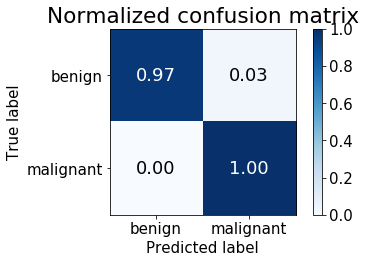

In [35]:
class_names = ['benign', 'malignant']
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

In [36]:
accuracy_score(y_pred, y_test)

0.9788732394366197

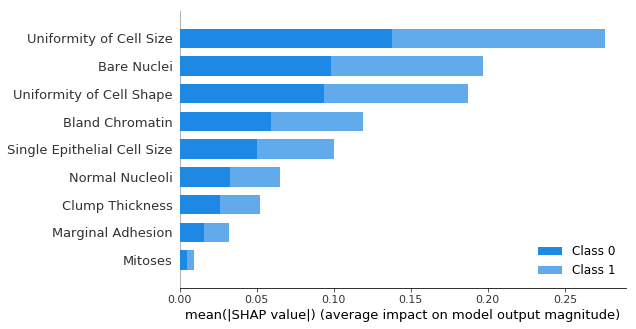

In [38]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(X_test)
feature_importance = shap.summary_plot(shap_values, X_test)       

In [41]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict
scores = defaultdict(list)
rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=27) 
names = list(clean_data.columns)
names.remove('Class')
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in rs.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    r = clf.fit(X_train, y_train)
    acc = r2_score(y_test, clf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, clf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print("Features sorted by their score:")
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 200


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 200


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

Features sorted by their score:
[(0.0681, 'Bare Nuclei'), (0.0676, 'Uniformity of Cell Shape'), (0.0434, 'Uniformity of Cell Size'), (0.0252, 'Clump Thickness'), (0.0216, 'Normal Nucleoli'), (0.0103, 'Bland Chromatin'), (0.0075, 'Single Epithelial Cell Size'), (-0.0007, 'Marginal Adhesion'), (-0.0037, 'Mitoses')]
